In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import shutil
from itertools import chain
from torchvision.transforms import Compose
import torch.nn.functional as F
import transformers
from collections import Counter

from PIL import Image
import time
from tqdm.notebook import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from torchvision.transforms import RandomResizedCrop,RandomHorizontalFlip,Normalize,ToTensor,Resize,Grayscale,InterpolationMode
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


In [ ]:
# data_path = Path.cwd()
# shutil.unpack_archive(data_path / Path("data.zip"), data_path)


In [2]:
class rellis_dataset(Dataset):
    """
    Using 6 classes
    """
    def __init__(self, data_root_dir, txt_file, transform=None, target_transform=None):
        """
        data_root_dit: root directory of the dataset, e.g. './data/rellis'
        txt_file: path to the train.txt listing image files
        
        """
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.target_transform = target_transform
        with open(txt_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_root_dir, 'image', self.image_paths[index] + '.jpg')
        ann_path = os.path.join(self.data_root_dir, 'annotation', self.image_paths[index] + '_group6.png')
        image = Image.open(img_path).convert('RGB')
        annotation = Image.open(ann_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        annotation = (annotation*256).long() # turn the label to the interger
        
        annotation=(nn.functional.one_hot(annotation,6))
        annotation = np.transpose(annotation, (0,3,1,2))
        # print(annotation.shape)
        return image, annotation

In [4]:
transform = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),          
    ToTensor()])
target_transform = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),          
    ToTensor()])
example_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/val.txt', transform=transform, target_transform=target_transform)
number_of_samples = len(example_dataset)


print(f"The number of samples is: {number_of_samples}")


The number of samples is: 983


dataset

In [9]:


batch_size = 8

transforms_1 = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),          
    ToTensor()])

train_dir = './train'
train_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/train.txt', transform=transforms_1, target_transform=transforms_1)

val_dir = './val'
val_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/val.txt', transform=transforms_1, target_transform=transforms_1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

CNN Block

Encoder Block

Decoder block

model

In [6]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 6
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size=kernel_size)
        self.dc5 = DownConv3(512, 512, kernel_size=kernel_size)

        self.uc5 = UpConv3(512, 512, kernel_size=kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size=kernel_size)
        self.uc1 = UpConv2(64, 6, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)
        x, mp5_indices, shape5 = self.dc5(x)

        # Decoder
        x = self.uc5(x, mp5_indices, output_size=shape5)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)

        return x
    

model=ImageSegmentation(3)
model.uc1.seq[5] = nn.Softmax(dim=1)

trainning

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        # pred_mask = F.softmax(pred_mask, dim=1)
        # pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


def compute_accuracy(testDataLoader,loss_fn,model,device):

    model.eval()  
    total_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn.calculate_average_dice_loss(outputs, labels.squeeze(1))
            # loss = loss_fn(outputs.float, labels.squeeze(1).float)
            # test_accuracy += pixel_accuracy(output, mask)
            val_accuracy += mIoU(outputs, labels.squeeze(1))
            total_loss += loss.item()

    return total_loss / len(testDataLoader), val_accuracy / len(testDataLoader)

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0
        # print(input.shape,target.shape)
        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)
        # print(num_channels)

        # Calculate Dice loss for each channel
        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            # print(input_channel.shape,target_channel.shape)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        # Calculate average Dice loss
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss
    
dice_loss=DiceLoss()

def train(model, dataloader, loss_fn, optimizer, device, ldl, lts): 
    model.train()  
    total_loss = 0
    train_accuracy = 0 

    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad() 
        outputs = model(inputs)
        # print(inputs.shape)
        # print(outputs.shape)
        # print(labels.squeeze(1).shape)

        loss = loss_fn.calculate_average_dice_loss(outputs, labels.squeeze(1))
        # loss = loss_fn(outputs.float, labels.squeeze(1).float)
        train_accuracy += mIoU(outputs, labels.squeeze(1))

        loss.backward()     
        optimizer.step()   

        total_loss += loss.item()

    return total_loss / ldl, train_accuracy / ldl

In [10]:
import torch.optim as optim


ldl = len(train_dataloader)

num_epochs = 50

optimizer = optim.Adam(model.parameters(), lr=0.001)


if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

ImageSegmentation(
  (bn_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc1): DownConv2(
    (seq): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dc2): DownConv2(
    (seq): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2

In [ ]:

train_losses = []
cross_losses = []
bestScore=1

for epoch in range(num_epochs):
    train_loss,train_acc = train(model, train_dataloader,dice_loss, optimizer, device, ldl, ldl*4)
    Current_loss,val_acc = compute_accuracy(val_dataloader,dice_loss, model,device)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    print(f'train Acc: {train_acc:.4f}')
    print(f'val Acc: {val_acc:.4f}')

    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve

    
    
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')



In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(cross_losses, label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show(block=False)


torch.Size([3, 256, 256])
torch.Size([1, 6, 256, 256])
torch.Size([256, 256])
Class Balance:
Class 0: 64963701
Class 5: 34011268
Class 4: 35665572
Class 2: 72680773
Class 3: 6781824
Class 1: 2296734


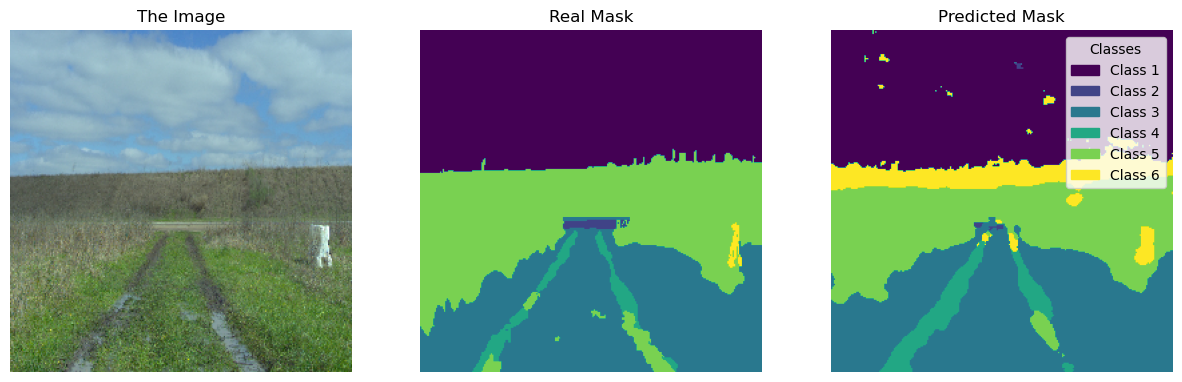

In [58]:


model = ImageSegmentation(3)
model.load_state_dict(torch.load('best_model222.pt', map_location=device))
image_tensor,annotation = example_dataset[763]#645  #876
print(image_tensor.shape)
image_tensor1 = image_tensor.unsqueeze(0).repeat(1, 1, 1, 1)

with torch.no_grad():
    pred = model(image_tensor1)
print(pred.shape)
pred = torch.argmax(pred, dim=1).squeeze(0)
print(pred.shape)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_tensor.permute(1, 2, 0))
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow((torch.argmax(annotation, dim=1).squeeze(0))/256)
plt.title("Real Mask")
plt.axis('off')

num_classes = model.out_channels  # Replace with appropriate way to get num_classes

# Create a colormap for the classes
cmap = matplotlib.colormaps['viridis']  # Choose a colormap with enough colors for your classes
norm = plt.Normalize(vmin=0, vmax=num_classes - 1)  # Normalize values to colormap range

# Get the predicted mask as numpy array
pred_np = pred.cpu().numpy()  # Move to CPU and remove extra dimension

# Create a new figure for the colormap legend
# fig_legend, ax_legend = plt.subplots(figsize=(4, 1))  # Adjust size as needed
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Set an empty array to avoid data plotting
# ax_legend.set_title('Colormap')
# plt.colorbar(sm, ax=ax_legend, label='Classes')  # Add labels for each color

# Loop through each class and create a legend patch with corresponding color
patches = []
for i in range(num_classes):
  color = cmap(norm(i))
  patch = plt.Rectangle((0, 0), 1, 1, color=color, label=f"Class {i+1}")
  patches.append(patch)


plt.subplot(1, 3, 3)
plt.imshow(pred_np/256)
plt.title("Predicted Mask")
plt.axis('off')

plt.legend(handles=patches, title="Classes")  # Add legend with class labels

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()
def get_class_balance(dataset):
        """
        Calculates the pixel count for each class in the dataset.

        Returns:
            Counter: A Counter object containing the class labels and their corresponding pixel counts.
        """
        class_counts = Counter()
        for image, annotation in dataset:
            # Convert one-hot encoded annotation to integer labels
            labels = torch.argmax(annotation, dim=1).flatten()

            # Count pixels for each class
            class_counts.update(labels.tolist())

        return class_counts
class_counts = get_class_balance(train_dataset)

# Print the class labels and their pixel counts
print("Class Balance:")
for class_label, pixel_count in class_counts.items():
    print(f"Class {class_label}: {pixel_count}")
